# Efficient Frontier Portfolio Optimisation for Strategic Asset Allocation 
- *by Chee-Foong*
- *Mar 2020*

## Importing libraries and functions
- yfinance==0.1.54
- scikit-image==0.15.0
- scikit-learn==0.21.3
- scipy==1.4.1
- seaborn==0.9.0
- pandas==0.25.3
- pyportfolioopt==0.5.4
- matplotlib==3.1.3
- numpy==1.17.2


In [1]:
import sys  
sys.path.append('../src') 
from edge import *

In [2]:
import numpy as np
import pandas as pd

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()
plt.style.use('ggplot')

## Extracting Data from Yahoo
Select list of interested yahoo tickers

In [3]:
tickers = ['LQD','HYG','EFA','^RUA','AGG','^GSPC','GLD','GOVT','SPY','QQQ','EMB',
          'AAPL','GOOG','TSLA','FB','NVDA','AMD','BABA','MSFT','AMZN']

Extracting data from yahoo

In [4]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start="2015-01-01", end="2020-01-01")

[*********************100%***********************]  20 of 20 completed


Filtering data for this analysis
- by tickers
- by dates
- by price type

In [5]:
tickers = ['AGG','SPY','GLD','HYG','GOVT']

In [6]:
prices = data['2018':'2020']['Adj Close'][tickers]
returns = prices.pct_change().dropna()
# returns = np.log(prices/prices.shift(1)).dropna()
cum_returns = ((1 + returns).cumprod()-1) 

In [7]:
prices

,AGG,SPY,GLD,HYG,GOVT
Date,,,,,
2018-01-02,102.676094,258.858276,125.150002,78.069382,23.963703
2018-01-03,102.685486,260.495544,124.820000,78.444817,23.982868
2018-01-04,102.619644,261.593475,125.459999,78.578873,23.973289
2018-01-05,102.553833,263.336731,125.330002,78.632545,23.963703
2018-01-08,102.525635,263.818329,125.309998,78.569969,23.954123
...,...,...,...,...,...
2019-12-24,111.911201,321.230011,141.270004,87.076469,25.854801
2019-12-26,112.010788,322.940002,142.380005,87.205345,25.884712
2019-12-27,112.160156,322.859985,142.330002,87.165688,25.914627


## Data Exploratory 
Show for each asset
- Annualised Return (%)
- Annualised Volatility (%)
- Sharpe Ratio

In [8]:
prettyAnalytics(returns, tickerlist)

,Annualised Return (%),Annualised Volatility (%),Sharpe Ratio
index,,,
iShares Core U.S. Aggregate Bon,4.36223,2.93072,1.48845
iShares iBoxx $ High Yield Corp,5.65863,4.78197,1.18333
iShares U.S. Treasury Bond ETF,3.89788,3.61812,1.07732
SPDR S&P 500,12.0588,14.9667,0.805711
SPDR Gold Trust,7.23312,10.7322,0.673963


Displaying the cumulative returns over the period

/Users/chancheefoong/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


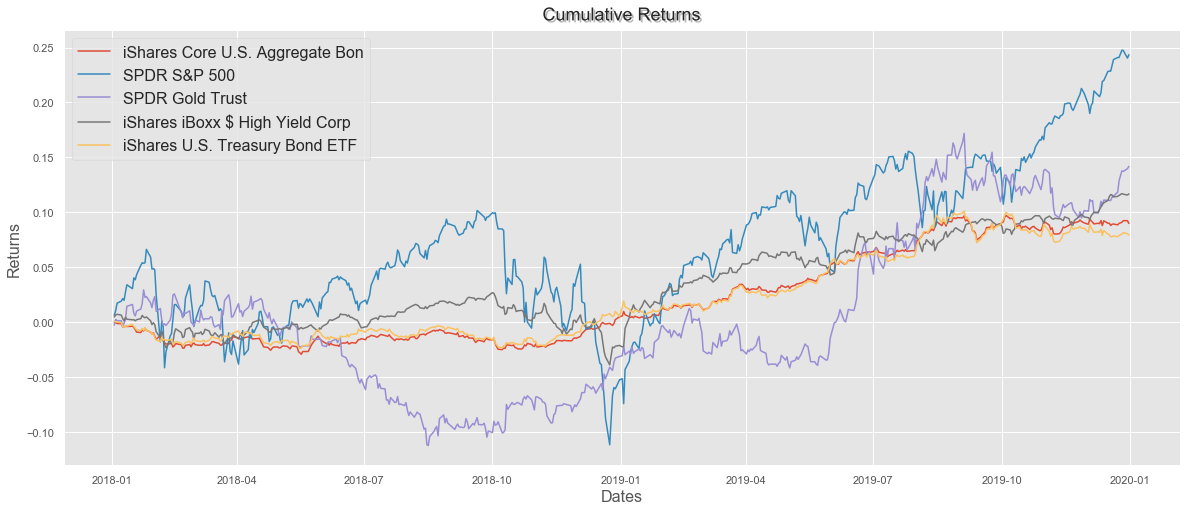

In [9]:
plotTimeSeries(cum_returns, 'Cumulative Returns', 'Dates', 'Returns', tickerlist)

Comparing the return distribution of the assets

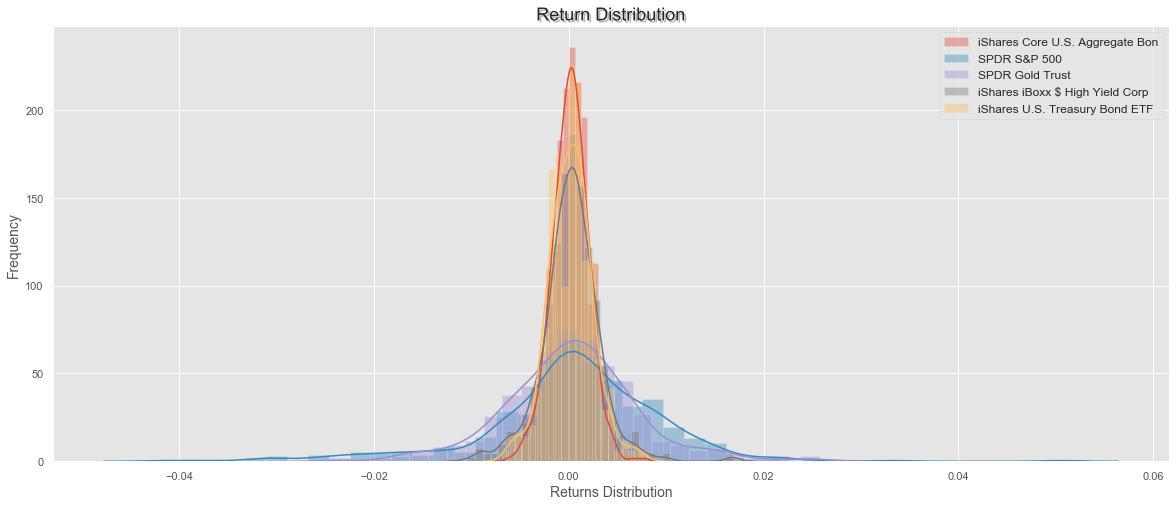

In [10]:
compareDistribution(returns, tickers, title='Return Distribution', tickermap = tickerlist)

In [11]:
# plotReturnDistribution(returns, 'SPY', 50, 'Returns Distribution')

Correlation Matrix of the assets

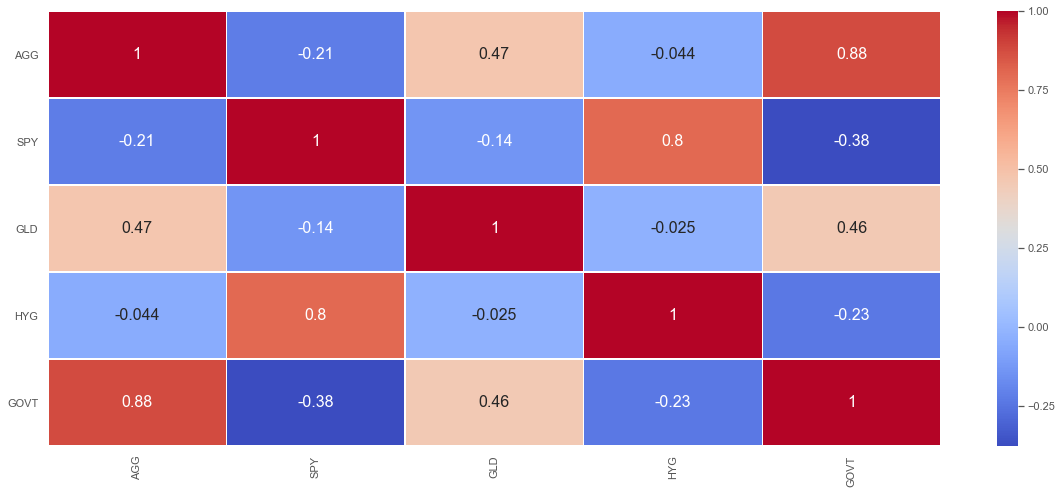

In [12]:
correlation_matrix = returns.corr()
plotCorrelationMatrix(correlation_matrix, 3)

## Plotting the Efficient Frontier
- Simulate asset allocation by random assigning of weights

An simulated example

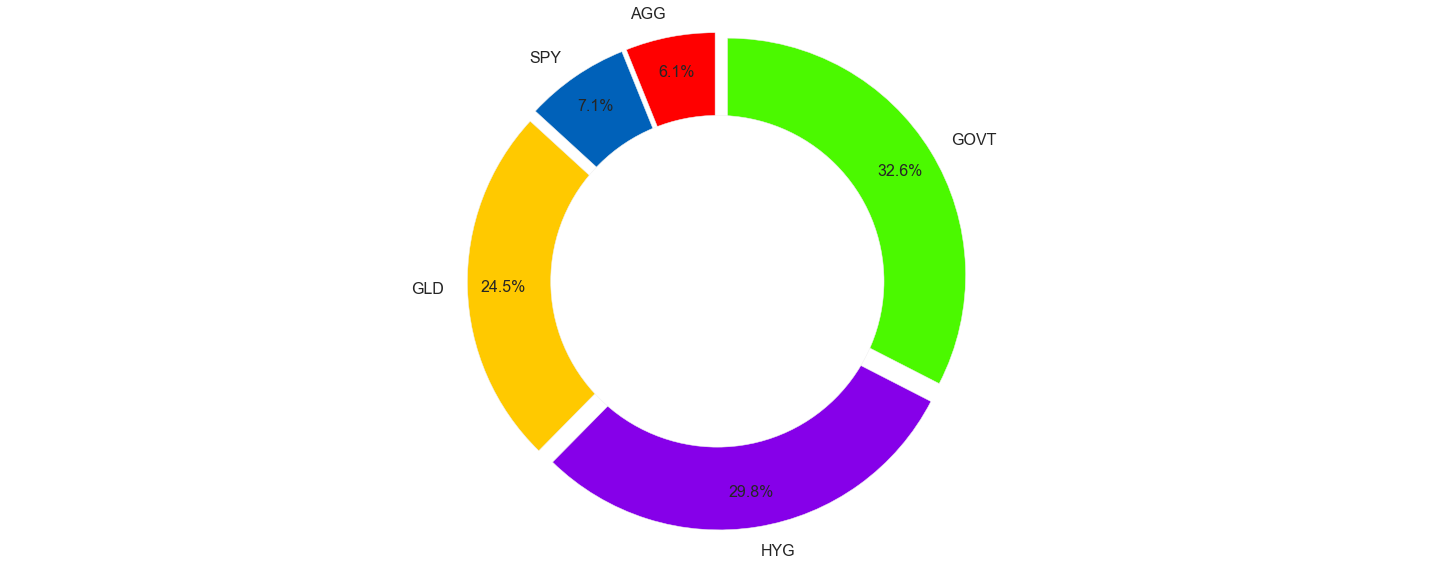

In [13]:
allocation = pd.DataFrame(data = {'Simulated': generateWgts(len(tickers)), 
                                  'Balanced': 1/len(tickers) * np.ones(len(tickers))},
                          index = tickers)
drawPie(allocation, 'Simulated', tickers)

Simulated returns of 5 portfolios and plotting their respective cumulative returns series 

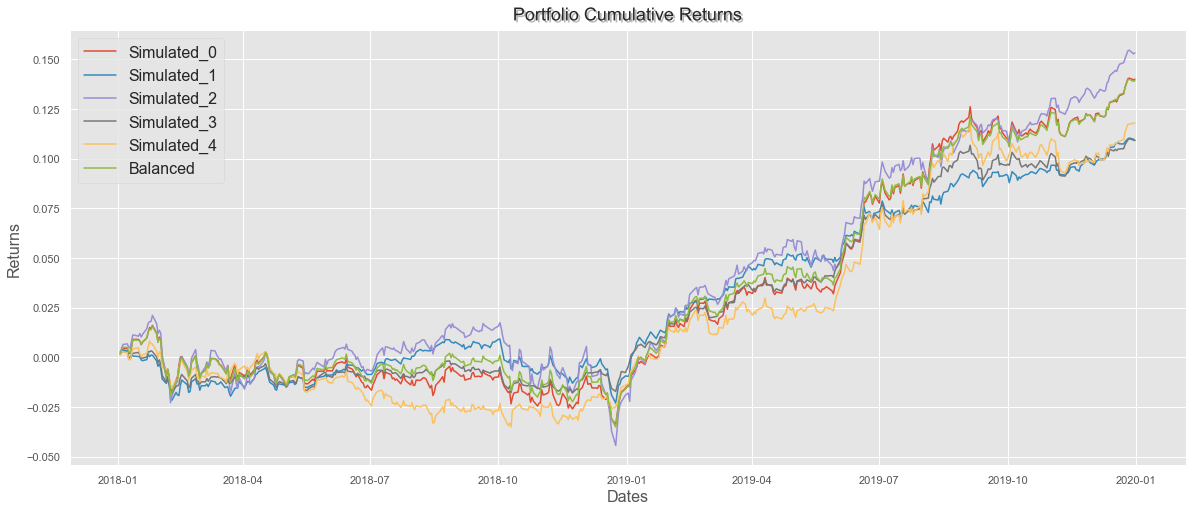

In [14]:
allocation = simAllocation(5, tickers)
port_returns = returns.dot(allocation)
port_cum_returns = ((1 + port_returns).cumprod()-1) 
plotTimeSeries(port_cum_returns, 'Portfolio Cumulative Returns', 'Dates', 'Returns')

Set the number of simulated portfolios and plotting the efficient frontier

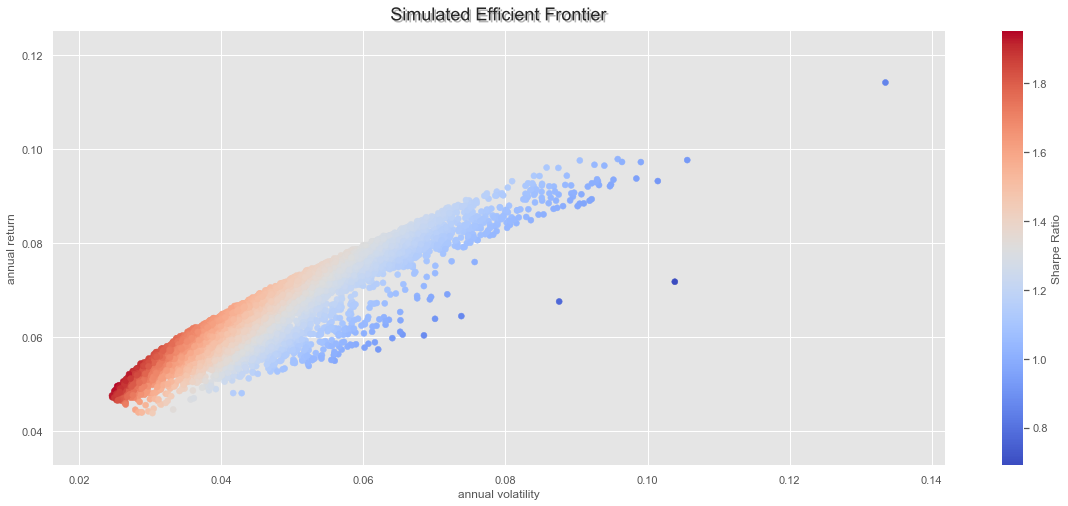

In [15]:
NUM_OF_SIMULATION = 10000
plotEfficientFrontier(returns, tickers, NUM_OF_SIMULATION)

## Finding the optimal portfolio

- Using PyPortfolioOpt python library for portfolio optimization
- to find portfolio with minimum volatility and max sharpe ratio

In [16]:
# !pip install PyPortfolioOpt
# prettyAnalytics(returns, tickerlist)

# Import the packages 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

### Build efficient frontier model using PyPortfolioOpt

In [17]:
# Calculate expected returns
expected_returns_daily = expected_returns.mean_historical_return(prices)

# Calculate the covariance matrix
covariance_matrix = risk_models.sample_cov(prices)

# Obtain the efficient frontier
ef = EfficientFrontier(expected_returns_daily, covariance_matrix)

### Performance numbers at maximum sharpe ratio

In [18]:
# Select a chosen optimal portfolio
ef.max_sharpe(risk_free_rate=0.00)
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.65581, 'SPY': 0.03657, 'GLD': 0.0, 'HYG': 0.25439, 'GOVT': 0.05323}
Expected annual return: 4.9%
Annual volatility: 2.5%
Sharpe Ratio: 1.96


(0.049487627965691755, 0.025266901729277622, 1.958595022687279)

### Performance numbers at minimum volatility
**Important Note:** Issue raised due to bug in minimum volatility calculations 
- https://github.com/robertmartin8/PyPortfolioOpt/issues/75

In [19]:
# Select a chosen portfolio with minimal volatiliy
ef.min_volatility()
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.35543, 'SPY': 0.0, 'GLD': 0.0, 'HYG': 0.28405, 'GOVT': 0.36052}
Expected annual return: 4.6%
Annual volatility: 2.5%
Sharpe Ratio: 1.85


(0.045630725764038954, 0.02462747815487289, 1.8528379348094266)

### Plotting the efficient frontier
- using increasing volatility steps (vsteps)
- vsteps set at 0.0005
- risk-free rate (rf) set at 0.0

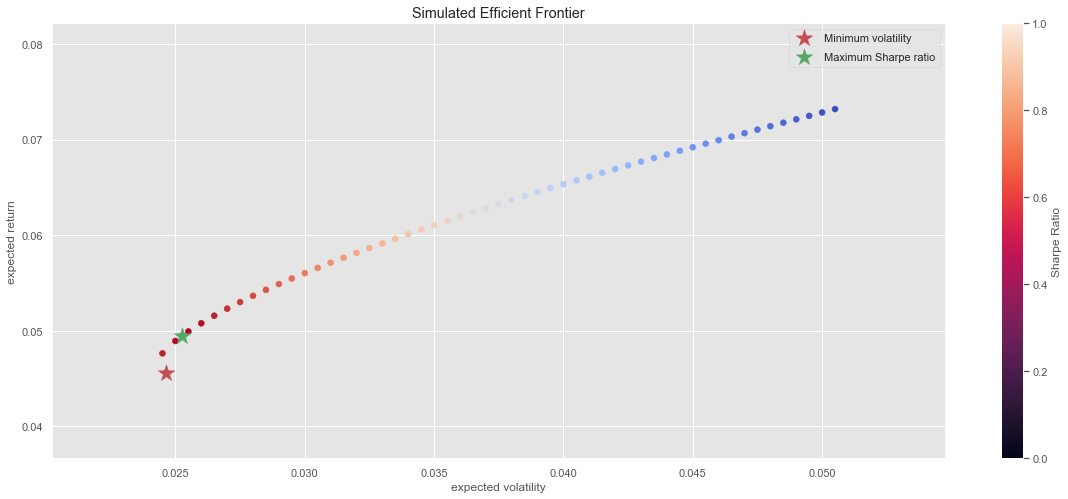

In [20]:
plotEF(ef, vsteps=0.0005, rf=0.0)

## Portfolio Asset Allocation
- Based on range of returns and volatility on the efficient frontier
- Select either your preferred target return or target volatility to derive the weights of your portfolio

In [22]:
TARGET_RETURN = 0.06

# Select a minimal risk for a target return
ef.efficient_return(TARGET_RETURN)
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.25776, 'SPY': 0.1494, 'GLD': 0.10747, 'HYG': 0.22987, 'GOVT': 0.25549}
Expected annual return: 6.0%
Annual volatility: 3.5%
Sharpe Ratio: 1.71


(0.05999999999193297, 0.03515707343437526, 1.706626693599224)

### Performance numbers at targeted risk 

In [23]:
TARGET_RISK = 0.04

# Select an optimal return for a target risk
ef.efficient_risk(TARGET_RISK, risk_free_rate = 0.00)
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.63583, 'SPY': 0.23334, 'GLD': 0.13083, 'HYG': 0.0, 'GOVT': 0.0}
Expected annual return: 6.5%
Annual volatility: 4.0%
Sharpe Ratio: 1.63


(0.06533742029211148, 0.040000001133726794, 1.6334354610060484)

# Acknowledgment
Thank you for all your contributions
- https://github.com/robertmartin8/PyPortfolioOpt
- https://github.com/mscandizzo/PortfolioTheory
- https://medium.com/@mariano.scandizzo/strategic-asset-allocation-with-python-c9afef392e90
- https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
- https://blog.quantinsti.com/portfolio-management-strategy-python/

In [ ]:
# ef_data = genEFdata(ef, vsteps=0.0005, rf=0.0)

In [ ]:
# balanced = {}
# bal_wgts = iter(1/len(tickers) * np.ones(len(tickers)))
# for ticker in tickers:
#     balanced[ticker] = next(bal_wgts)
# balanced['index'] = 'balanced'

# wgts = [min_vol, max_sharpe, balanced]

# wgts = {}
# for i in range(0,num):
#     wgts['Simulated_' + str(i)] = generateWgts(len(tickers))
# wgts['Balanced'] = 1/len(tickers) * np.ones(len(tickers))